# Malware detection

A toy dataset for malware detection. It contains only two classes (benign and malware).

This notebook will address the topic of feature importance and feature selection.

In [1]:
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 7]

In [2]:
df = pl.read_csv('https://cloud.hrun.duckdns.org/s/CSEFd6fBQRnryk2/download/malware_dataset.csv')
df.head()

hash,millisecond,classification,state,usage_counter,prio,static_prio,normal_prio,policy,vm_pgoff,vm_truncate_count,task_size,cached_hole_size,free_area_cache,mm_users,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,lock,utime,stime,gtime,cgtime,signal_nvcsw
str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""42fb5e2ec009a0…",0,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a0…",1,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a0…",2,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a0…",3,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a0…",4,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0


In [3]:
mapping = {'benign':0, 'malware':1} 
df = df.with_columns(pl.col('classification').map_dict(mapping).alias('classification'))

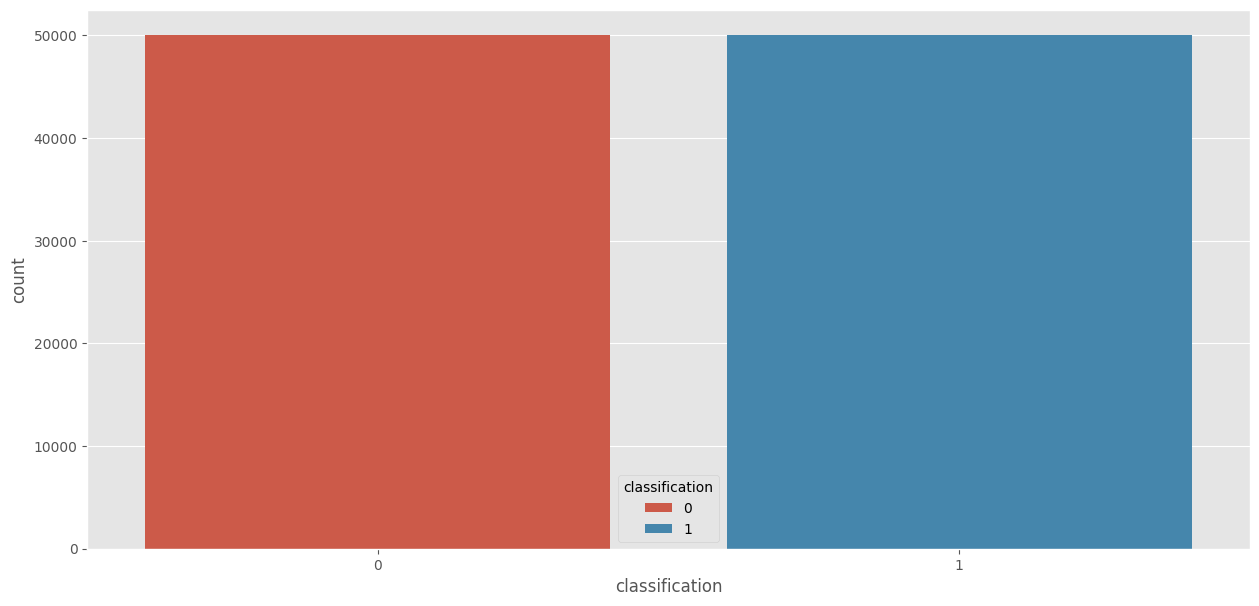

In [4]:
sns.countplot(data=df, x='classification', hue='classification')
plt.show()

In [5]:
df = df.drop(['hash', 'millisecond'])
df.describe()

describe,classification,state,usage_counter,prio,static_prio,normal_prio,policy,vm_pgoff,vm_truncate_count,task_size,cached_hole_size,free_area_cache,mm_users,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,lock,utime,stime,gtime,cgtime,signal_nvcsw
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.5,157768.33536,0.0,3.0697e9,18183.90007,0.0,0.0,0.0,15312.73951,0.0,0.0,9.58777,728.46543,8771.13948,0.0,266.49112,117.92024,127.67815,205.32485,0.0,117.92024,2435.97361,348313.0716,32.99116,2.05313,117.92024,1.10919,3.2044e9,385415.45197,4.05931,1.66142,0.0,0.0
"""std""",0.500003,936172.583333,0.0,296306.144183,4609.792765,0.0,0.0,0.0,3256.475008,0.0,0.0,46.504908,84.475361,3785.30516,0.0,311.996779,3.116892,22.277995,112.717875,0.0,3.116892,2605.564669,9117.720632,52.730176,13.881382,3.116892,2.160466,0.0,10144.036494,0.822848,3.26304,0.0,0.0
"""min""",0.0,0.0,0.0,3.0692e9,13988.0,0.0,0.0,0.0,9695.0,0.0,0.0,0.0,612.0,2588.0,0.0,4.0,112.0,92.0,29.0,0.0,112.0,0.0,337688.0,0.0,0.0,112.0,0.0,3.2044e9,371782.0,3.0,0.0,0.0,0.0
"""25%""",0.0,0.0,0.0,3.0695e9,14352.0,0.0,0.0,0.0,12648.0,0.0,0.0,0.0,651.0,6428.0,0.0,99.0,114.0,112.0,112.0,0.0,114.0,0.0,341974.0,1.0,0.0,114.0,0.0,3.2044e9,378208.0,3.0,0.0,0.0,0.0
"""50%""",1.0,0.0,0.0,3.0697e9,16159.0,0.0,0.0,0.0,15245.0,0.0,0.0,1.0,725.0,7865.0,0.0,177.0,120.0,127.0,193.0,0.0,120.0,2017.0,347244.0,9.0,1.0,120.0,0.0,3.2044e9,383637.0,4.0,0.0,0.0,0.0
"""75%""",1.0,4096.0,0.0,3.0700e9,22182.0,0.0,0.0,0.0,17663.0,0.0,0.0,4.0,785.0,10684.0,0.0,327.0,120.0,138.0,273.0,0.0,120.0,4036.0,351667.0,46.0,1.0,120.0,1.0,3.2044e9,390324.0,5.0,1.0,0.0,0.0
"""max""",1.0,4.3266048e7,0.0,3.0702e9,31855.0,0.0,0.0,0.0,27157.0,0.0,0.0,515.0,995.0,28184.0,0.0,2810.0,120.0,196.0,755.0,0.0,120.0,9526.0,384520.0,365.0,256.0,120.0,18.0,3.2044e9,421913.0,7.0,15.0,0.0,0.0


## Drop columns with low variance

In [6]:
threshold = 0.5
df = df.drop([col.name for col in df.select(pl.all().std() < threshold) if col.item()])
df.describe()

describe,classification,state,prio,static_prio,vm_truncate_count,free_area_cache,mm_users,map_count,total_vm,shared_vm,exec_vm,reserved_vm,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,utime,stime,gtime
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.5,157768.33536,3.0697e9,18183.90007,15312.73951,9.58777,728.46543,8771.13948,266.49112,117.92024,127.67815,205.32485,117.92024,2435.97361,348313.0716,32.99116,2.05313,117.92024,1.10919,385415.45197,4.05931,1.66142
"""std""",0.500003,936172.583333,296306.144183,4609.792765,3256.475008,46.504908,84.475361,3785.30516,311.996779,3.116892,22.277995,112.717875,3.116892,2605.564669,9117.720632,52.730176,13.881382,3.116892,2.160466,10144.036494,0.822848,3.26304
"""min""",0.0,0.0,3.0692e9,13988.0,9695.0,0.0,612.0,2588.0,4.0,112.0,92.0,29.0,112.0,0.0,337688.0,0.0,0.0,112.0,0.0,371782.0,3.0,0.0
"""25%""",0.0,0.0,3.0695e9,14352.0,12648.0,0.0,651.0,6428.0,99.0,114.0,112.0,112.0,114.0,0.0,341974.0,1.0,0.0,114.0,0.0,378208.0,3.0,0.0
"""50%""",1.0,0.0,3.0697e9,16159.0,15245.0,1.0,725.0,7865.0,177.0,120.0,127.0,193.0,120.0,2017.0,347244.0,9.0,1.0,120.0,0.0,383637.0,4.0,0.0
"""75%""",1.0,4096.0,3.0700e9,22182.0,17663.0,4.0,785.0,10684.0,327.0,120.0,138.0,273.0,120.0,4036.0,351667.0,46.0,1.0,120.0,1.0,390324.0,5.0,1.0
"""max""",1.0,4.3266048e7,3.0702e9,31855.0,27157.0,515.0,995.0,28184.0,2810.0,120.0,196.0,755.0,120.0,9526.0,384520.0,365.0,256.0,120.0,18.0,421913.0,7.0,15.0


## Split the data

In [7]:
Y = df['classification']
X = df.drop(['classification'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

## Logistic Regression Feature Importance

We can fit a LogisticRegression model on the regression dataset and retrieve the coeff_ property that contains the coefficients found for each input variable.

These coefficients can provide the basis for a crude feature importance score. This assumes that the input variables have the same scale or have been scaled prior to fitting a model.

The complete example of logistic regression coefficients for feature importance is listed below.

              precision    recall  f1-score   support

      Benign       0.96      0.92      0.94     10030
     Malware       0.92      0.96      0.94      9970

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Feature: 0, Score: 0.05724
Feature: 1, Score: -0.35375
Feature: 2, Score: 2.50086
Feature: 3, Score: 0.25643
Feature: 4, Score: 0.43231
Feature: 5, Score: 5.33643
Feature: 6, Score: 1.20695
Feature: 7, Score: -1.04905
Feature: 8, Score: -1.90927
Feature: 9, Score: 5.62390
Feature: 10, Score: -1.19606
Feature: 11, Score: -1.90927
Feature: 12, Score: 5.12129
Feature: 13, Score: -8.38640
Feature: 14, Score: -1.43543
Feature: 15, Score: -0.03967
Feature: 16, Score: -1.90927
Feature: 17, Score: 0.79004
Feature: 18, Score: -14.70843
Feature: 19, Score: -0.35531
Feature: 20, Score: -1.81251


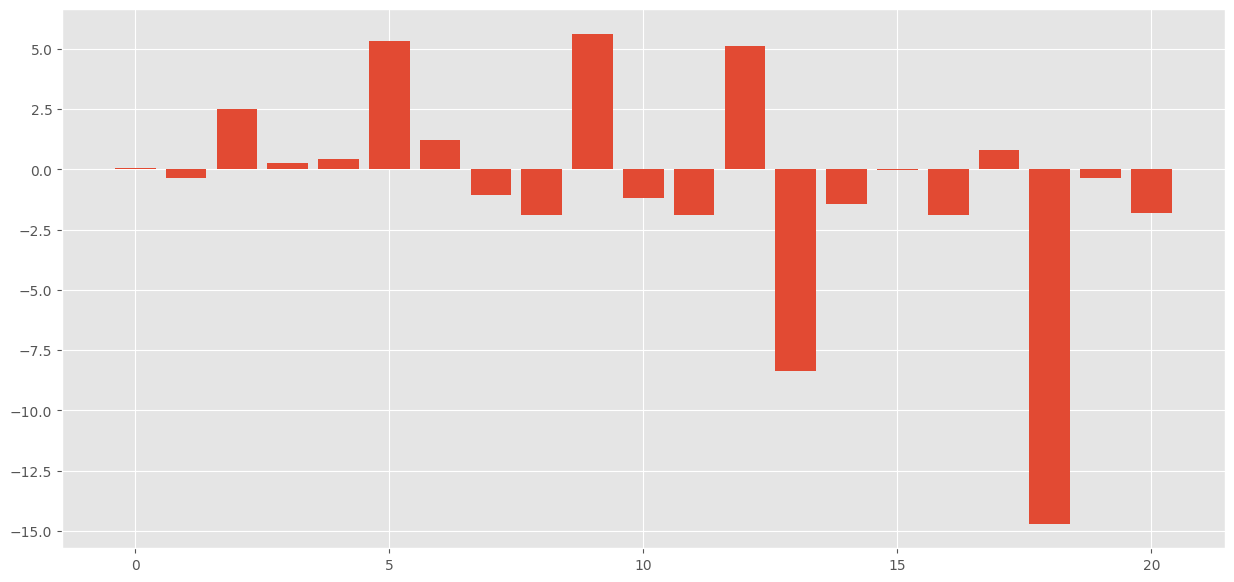

In [18]:
from sklearn.linear_model import LogisticRegression

# define the model
model = LogisticRegression(max_iter=1000)
# fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware']))

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Decision Tree Feature Importance

Decision tree algorithms like classification and regression trees (CART) offer importance scores based on the reduction in the criterion used to select split points, like Gini or entropy.

This same approach can be used for ensembles of decision trees, such as the random forest and stochastic gradient boosting algorithms.

Let’s take a look at a worked example of each.

### CART Feature Importance

We can use the CART algorithm for feature importance implemented in scikit-learn as the DecisionTreeRegressor and DecisionTreeClassifier classes.

After being fit, the model provides a feature_importances_ property that can be accessed to retrieve the relative importance scores for each input feature.

Let’s take a look at an example of this for regression and classification.

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     10030
     Malware       1.00      1.00      1.00      9970

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.01678
Feature: 2, Score: 0.53763
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00010
Feature: 5, Score: 0.00398
Feature: 6, Score: 0.00715
Feature: 7, Score: 0.04021
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.05585
Feature: 10, Score: 0.03340
Feature: 11, Score: 0.00191
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.06438
Feature: 14, Score: 0.00558
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.19836
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.02157
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.01309


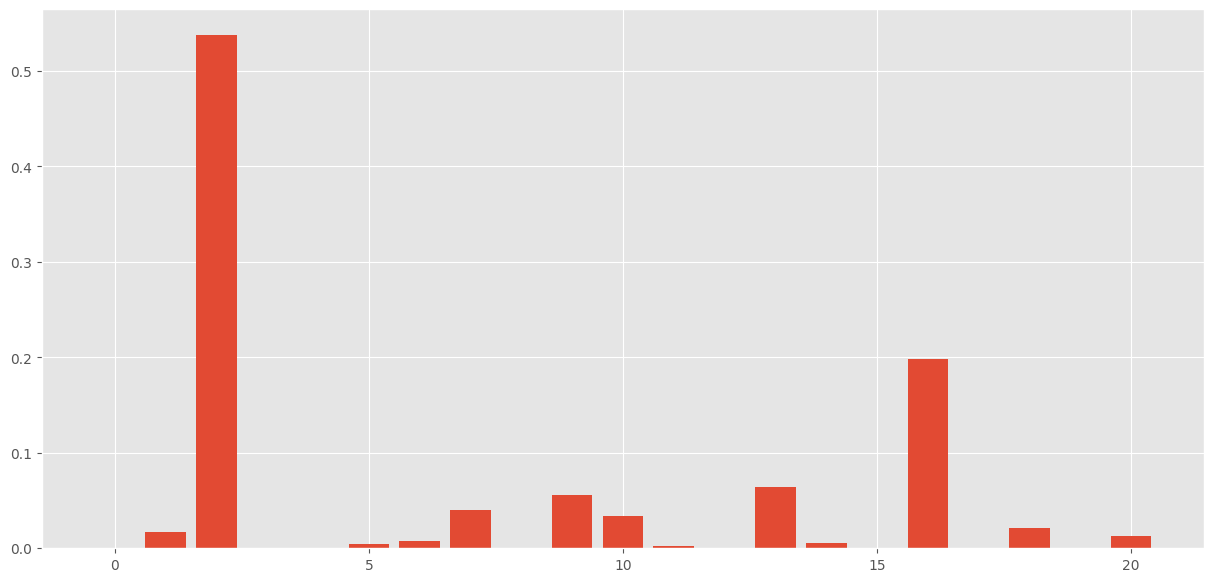

In [20]:
from sklearn.tree import DecisionTreeClassifier

# define the model
model = DecisionTreeClassifier()

# fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware']))

# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Random Forest Feature Importance

We can use the Random Forest algorithm for feature importance implemented in scikit-learn as the RandomForestRegressor and RandomForestClassifier classes.

After being fit, the model provides a feature_importances_ property that can be accessed to retrieve the relative importance scores for each input feature.

This approach can also be used with the bagging and extra trees algorithms.

Let’s take a look at an example of this for regression and classification.

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     10030
     Malware       1.00      1.00      1.00      9970

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Feature: 0, Score: 0.00115
Feature: 1, Score: 0.02938
Feature: 2, Score: 0.22951
Feature: 3, Score: 0.04788
Feature: 4, Score: 0.09168
Feature: 5, Score: 0.02740
Feature: 6, Score: 0.03771
Feature: 7, Score: 0.02035
Feature: 8, Score: 0.05744
Feature: 9, Score: 0.05859
Feature: 10, Score: 0.02266
Feature: 11, Score: 0.05264
Feature: 12, Score: 0.02952
Feature: 13, Score: 0.10827
Feature: 14, Score: 0.02072
Feature: 15, Score: 0.00112
Feature: 16, Score: 0.04047
Feature: 17, Score: 0.00917
Feature: 18, Score: 0.09208
Feature: 19, Score: 0.01426
Feature: 20, Score: 0.00801


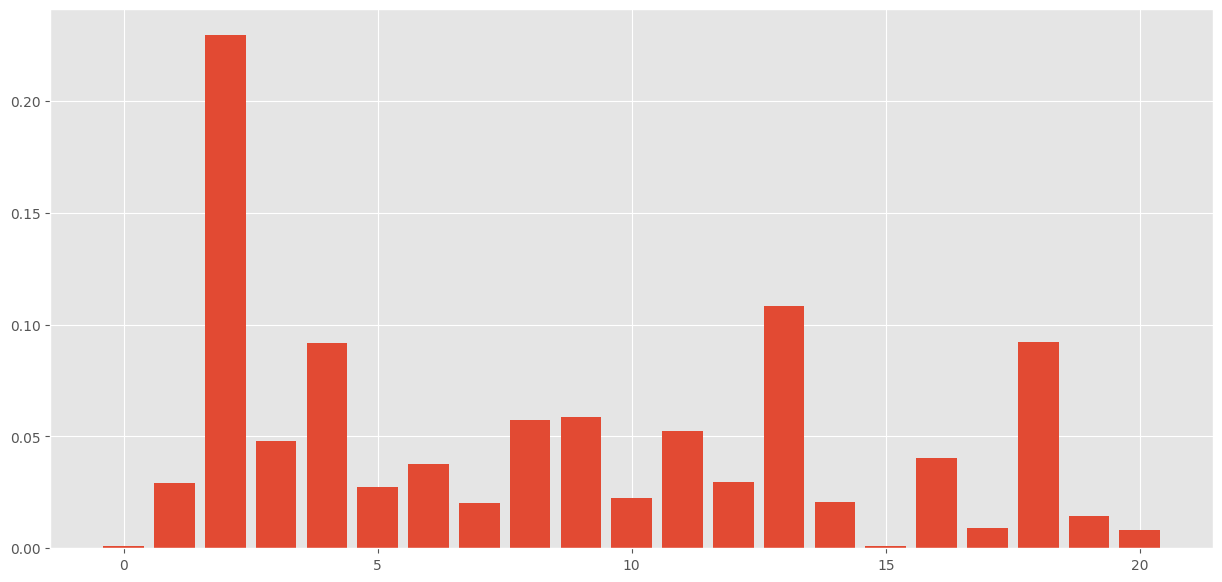

In [21]:
from sklearn.ensemble import RandomForestClassifier

# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware']))

# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Permutation Feature Importance

Permutation feature importance is a technique for calculating relative importance scores that is independent of the model used.

First, a model is fit on the dataset, such as a model that does not support native feature importance scores. Then the model is used to make predictions on a dataset, although the values of a feature (column) in the dataset are scrambled. This is repeated for each feature in the dataset. Then this whole process is repeated 3, 5, 10 or more times. The result is a mean importance score for each input feature (and distribution of scores given the repeats).

This approach can be used for regression or classification and requires that a performance metric be chosen as the basis of the importance score, such as the mean squared error for regression and accuracy for classification.

Permutation feature selection can be used via the permutation_importance() function that takes a fit model, a dataset (train or test dataset is fine), and a scoring function.

Let’s take a look at this approach to feature selection with an algorithm that does not support feature selection natively, specifically k-nearest neighbors.

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# define the model
model = KNeighborsClassifier()

# fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware']))

# perform permutation importance
results = permutation_importance(model, X_train, y_train, scoring='accuracy')

# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     10030
     Malware       1.00      1.00      1.00      9970

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



KeyboardInterrupt: 